## **CV HW4: Multi-object Tracking (MOT) with Detection**
**Detection**: YOLOv5, 
**Tracking**: Simple Online Realtime Tracking (SORT)

---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **2. Install requirements**

# **3. Import libraries**

In [10]:
import torch
import torchvision
import cv2
import sys
sys.path.insert(1,'/content/drive/MyDrive/cv_assignment 3/Homework3/sort-master')
import matplotlib
from collections import namedtuple, OrderedDict

# **4. Load YOLOv5 detector from torch hub**

In [11]:
yolov5_detector = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained = True)
yolov5_detector.float()
yolov5_detector.eval()

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-7 Python-3.10.11 torch-2.0.0+cu118 CPU

Fusing layers... 


requirements: /root/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

# **5. Import SORT library**

In [12]:
!pip install filterpy
from sort import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#**6. Perform tracking with detection**

In [13]:
# Write your code here to perform tracking with detection using the provided YOLOv5 model and the SORT implementation
import os
import matplotlib.pyplot as plt
images = []
for dirname, _, filenames in os.walk('/content/drive/MyDrive/cv_assignment 3/Homework3/KITTI_17_images'):
    for filename in sorted(filenames):
        images.append(plt.imread(os.path.join(dirname, filename)))

In [14]:
all_detections = []
index = 0
print(images[0].shape)
for image in images:
    all_detections.append(yolov5_detector(image))
    index+=1

(370, 1224, 3)


image 1/1: 370x1224 5 persons, 4 bicycles, 1 bus
Speed: 2.5ms pre-process, 129.3ms inference, 1.0ms NMS per image at shape (1, 3, 224, 640)


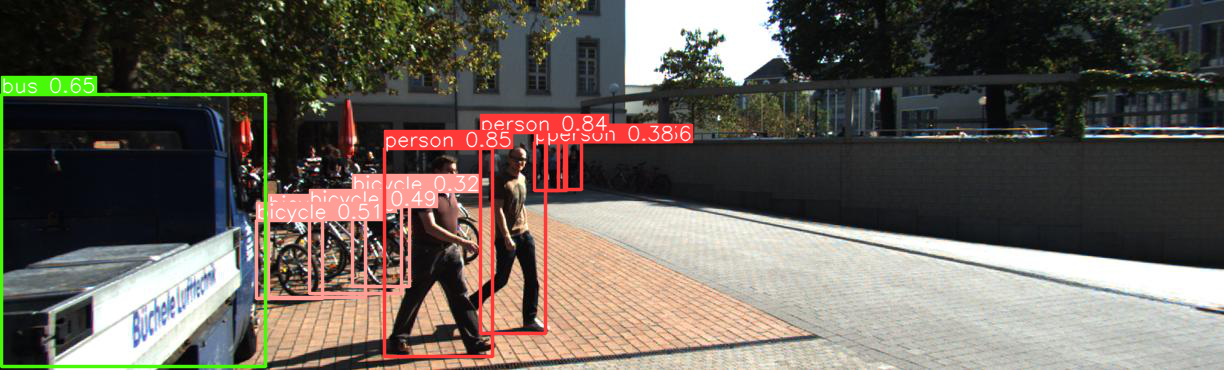

In [15]:
#An exmaple of what detection looks like
sample_detection = yolov5_detector(images[0])
sample_detection.print()
sample_detection.show()

image 1/1: 370x1224 3 persons, 3 bicycles, 1 car, 1 bus
Speed: 1.9ms pre-process, 123.4ms inference, 0.9ms NMS per image at shape (1, 3, 224, 640)


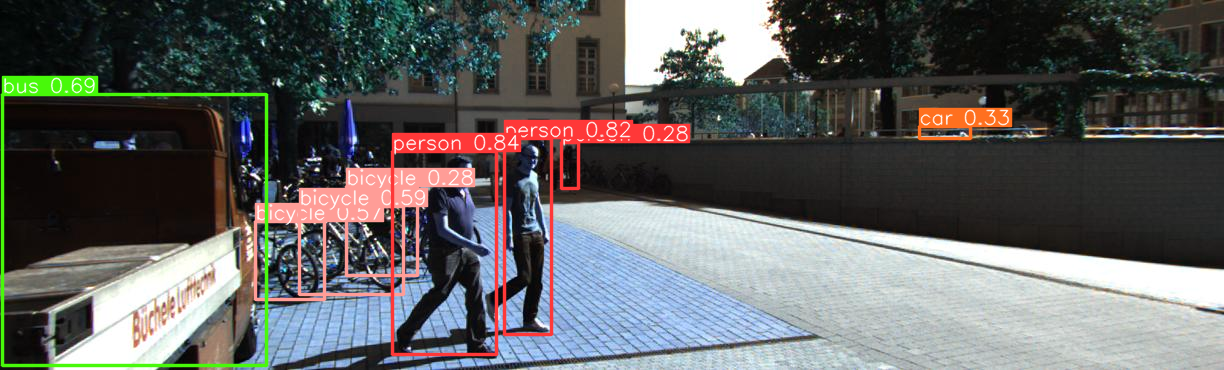

[tensor([[3.92355e+02, 1.51862e+02, 4.96766e+02, 3.54379e+02, 8.43073e-01, 0.00000e+00],
        [5.04508e+02, 1.38421e+02, 5.51442e+02, 3.34378e+02, 8.20089e-01, 0.00000e+00],
        [2.64108e+00, 9.42994e+01, 2.66975e+02, 3.65987e+02, 6.88120e-01, 5.00000e+00],
        [2.99527e+02, 2.06648e+02, 4.03422e+02, 2.94582e+02, 5.91515e-01, 1.00000e+00],
        [2.55133e+02, 2.21347e+02, 3.24013e+02, 2.99333e+02, 5.71136e-01, 1.00000e+00],
        [9.19737e+02, 1.26876e+02, 9.70549e+02, 1.38369e+02, 3.26312e-01, 2.00000e+00],
        [5.61069e+02, 1.42945e+02, 5.78934e+02, 1.88062e+02, 2.82430e-01, 0.00000e+00],
        [3.46924e+02, 1.86320e+02, 4.17466e+02, 2.75507e+02, 2.80887e-01, 1.00000e+00]])]


In [40]:
current_detection =[]
img = cv2.imread('/content/drive/MyDrive/cv_assignment 3/Homework3/KITTI_17_images/000002.jpg')
det = yolov5_detector(img)
# det.print()
# det.show()
print(det.xyxy)
new_det = []
for guess in det.xyxy:
    for i in guess:
      if(i[5] == 0):
        img = cv2.rectangle(img, (int(i[0]),int(i[1])), (int(i[2]), int(i[3])), (255, 0, 0))
        new_det.append([i[0],i[1],i[2], i[3], i[4]])     

plt.imshow(img)
plt.show()

In [17]:
from sort import *
mot_tracker = Sort()
people_detections = []
original_people_detection = []
for detection in all_detections:
    current_detection =[]
    for guess in detection.xyxy:
        for i in guess:
            if(int(i[5]) < 0.1):
                current_detection.append(i[0:5].numpy().tolist())        
    current_detection = np.array(current_detection)
    original_people_detection.append(current_detection)
    # print(current_detection)
    # print(len(current_detection), end = " to " )
    track_bbs_ids = mot_tracker.update(current_detection)
    # print(len(track_bbs_ids))
    people_detections.append(track_bbs_ids)

In [18]:
print(people_detections[0])
print(len(people_detections))
print(all_detections[0])
print(original_people_detection[0])

[[     534.54      142.13      558.45      190.19           5]
 [     564.07      142.53      581.75      189.22           4]
 [     546.99      142.95      566.74      190.65           3]
 [     480.55      132.94      545.75      333.83           2]
 [      384.9      148.92      492.01      356.49           1]]
145
image 1/1: 370x1224 5 persons, 4 bicycles, 1 bus
Speed: 4.4ms pre-process, 153.0ms inference, 2.1ms NMS per image at shape (1, 3, 224, 640)
[[      384.9      148.92      492.01      356.49      0.8528]
 [     480.55      132.94      545.75      333.83     0.83854]
 [     546.99      142.95      566.74      190.65     0.38131]
 [     564.07      142.53      581.75      189.22      0.3552]
 [     534.54      142.13      558.45      190.19     0.27567]]


In [36]:
colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0), (0, 255, 255), (255, 0, 255), (255, 255, 0), (255, 255, 255), (0, 0, 0), 
          (128, 0, 0), (0, 128, 0), (0, 0, 128), (128, 0, 128), (128, 128, 0), (128, 128, 128), (255, 128, 0), (128, 255, 0), 
          (0, 128, 255), (255, 0, 128), (255, 255, 128), (128, 255, 255), (255, 128, 255), (192, 192, 192), (128, 128, 255), 
          (255, 0, 0), (255, 255, 0), (0, 255, 0), (0, 128, 128), (255, 0, 255), (128, 0, 128), (0, 255, 255), (0, 0, 255), 
          (165, 42, 42), (0, 128, 128), (255, 165, 0), (255, 192, 203), (128, 0, 0), (128, 128, 0), (0, 128, 0), (128, 128, 128), 
          (0, 128, 128), (0, 0, 128), (0, 0, 255), (255, 0, 0), (255, 255, 0), (0, 255, 0), (0, 128, 128), (255, 0, 255), 
          (128, 0, 128), (0, 255, 255), (0, 0, 255), (165, 42, 42), (0, 128, 128), (255, 165, 0), (255, 192, 203), (128, 0, 0), 
          (128, 128, 0), (0, 128, 0), (128, 128, 128), (0, 128, 128), (0, 0, 128), (0, 0, 255), (255, 0, 0), (255, 255, 0), 
          (0, 255, 0), (0, 128, 128), (255, 0, 255), (128, 0, 128), (0, 255, 255), (0, 0, 255), (165, 42, 42), (0, 128, 128), 
          (255, 165, 0), (255, 192, 203), (128, 0, 0), (128, 128, 0), (0, 128, 0), (128, 128, 128), (0, 128, 128)]
print(len(colors))

78


In [37]:
from google.colab import files
index = 0
height, width, layers = images[0].shape  
video = cv2.VideoWriter("Output_2020248.avi", 0, 1, (width, height)) 
for i in range(145):
  img = images[index]
  for det in people_detections[index]:
    color = colors[int(det[4])%78]
    img = cv2.rectangle(img, (int(det[0]),int(det[1])), (int(det[2]), int(det[3])), color , thickness = 4)
  index+=1
  video.write(img) 
  cv2.imwrite(f'/content/drive/MyDrive/cv_assignment 3/Homework3/Final images/{index}.png',img)
  
files.download('Output_2020248.avi')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
file = []
for i in range(145):
  print(f'In {i+1}th image out of {len(people_detections[i])} we got ', end = '')
  index = 0
  for detection in people_detections[i]:
    for score_detection in original_people_detection[i]:
      # print(detection, score_detection)
      if abs(detection[0] - score_detection[0]) < 10 and abs(detection[1] - score_detection[1]) < 10 and abs(detection[2] - score_detection[2]) < 10 and abs(detection[3] - score_detection[3]) < 10:
        index+=1
        file.append([i+1, int(detection[4]), score_detection[0], score_detection[1], score_detection[2]-score_detection[0], score_detection[3]-score_detection[1], score_detection[4], -1, -1, -1])
        # print("adding value = ", file[-1])
        break
  print(index)

In 1th image out of 5 we got 5
In 2th image out of 3 we got 3
In 3th image out of 3 we got 3
In 4th image out of 2 we got 1
In 5th image out of 2 we got 1
In 6th image out of 2 we got 2
In 7th image out of 2 we got 2
In 8th image out of 2 we got 2
In 9th image out of 2 we got 2
In 10th image out of 2 we got 2
In 11th image out of 3 we got 2
In 12th image out of 4 we got 3
In 13th image out of 4 we got 4
In 14th image out of 6 we got 6
In 15th image out of 5 we got 4
In 16th image out of 5 we got 5
In 17th image out of 6 we got 6
In 18th image out of 7 we got 7
In 19th image out of 8 we got 8
In 20th image out of 8 we got 7
In 21th image out of 9 we got 8
In 22th image out of 9 we got 7
In 23th image out of 9 we got 6
In 24th image out of 8 we got 6
In 25th image out of 9 we got 8
In 26th image out of 9 we got 6
In 27th image out of 9 we got 7
In 28th image out of 9 we got 8
In 29th image out of 7 we got 6
In 30th image out of 5 we got 4
In 31th image out of 4 we got 3
In 32th image out

In [31]:
file2= file
file2.sort()
for row in file2:
  print(row)

[1, 1, 384.8951416015625, 148.9217987060547, 107.11553955078125, 207.5651397705078, 0.8528037667274475, -1, -1, -1]
[1, 2, 480.5475158691406, 132.93995666503906, 65.20358276367188, 200.8861541748047, 0.8385409116744995, -1, -1, -1]
[1, 3, 546.9912719726562, 142.9468536376953, 19.75146484375, 47.70729064941406, 0.38130640983581543, -1, -1, -1]
[1, 4, 564.071044921875, 142.53033447265625, 17.676513671875, 46.686859130859375, 0.35519883036613464, -1, -1, -1]
[1, 5, 534.5357055664062, 142.12652587890625, 23.91046142578125, 48.059234619140625, 0.27566787600517273, -1, -1, -1]
[2, 1, 391.58087158203125, 150.16587829589844, 105.24337768554688, 206.34400939941406, 0.8560642600059509, -1, -1, -1]
[2, 2, 502.5244140625, 138.3224639892578, 48.33660888671875, 195.3882293701172, 0.8348969221115112, -1, -1, -1]
[2, 4, 562.0631713867188, 143.50340270996094, 17.18707275390625, 44.29432678222656, 0.26210999488830566, -1, -1, -1]
[3, 1, 414.7610778808594, 148.28587341308594, 82.12564086914062, 209.37611

In [32]:
with open('detections.txt', 'w') as f:
  for row in file2:
    for i in range(len(row)):
      f.write(f'{row[i]}')
      if(i!= len(row)-1):
        f.write(',')
    f.write('\n')

# **7. Report Evaluation Metrics**

In [ ]:
# Use the Track-Eval kit to report the complete set of performance and accuracy metrics
# Comment on and interpret MOTA and MOTP values
#I have run it on my local machine, as I cant run the scripts in 
python .\TrackEval-master\scripts\run_mot_challenge.py --BENCHMARK MOT15 --SPLIT_TO_EVAL train --TRACKERS_TO_EVAL gt  --METRICS CLEAR Identity --GT_FOLDER "C:\Users\spars\Desktop\sem6\cv\Homework3\TrackEval-master\data\gt\mot_challenge" --TRACKERS_FOLDER "C:\Users\spars\Desktop\sem6\cv\Homework3\TrackEval-master\data\tracker\mot_challenge"